In [43]:
# !pip install git+https://github.com/treforevans/uci_datasets.git

In [44]:
import numpy as np
from uci_datasets import Dataset
import NTK
import matplotlib.pyplot as plt

from regression_tools import *

In [45]:
def normalize_to_unit_sphere(data):
    # Calculate the Euclidean norm (magnitude) of each data point
    norms = np.linalg.norm(data, axis=1)
    
    # Normalize the dataset to be on the unit sphere
    normalized_data = data / norms[:, np.newaxis]
    return normalized_data
def unzip_list(my_list):
    a,b = list(zip(*my_list))
    return list(a), list(b)

In [46]:
def run_experiment(dataset_name, params):
    depth = params['depth']
    fix_depth = params['fix_depth']
    rho_log10_lb = params['rho_log10_lb']
    rho_log10_ub = params['rho_log10_ub']
    num_sweep = params['num_sweep']
    
    data = Dataset(dataset_name)
    x_train, y_train, x_test, y_test = data.get_split(split=0)
    y_std = np.std(y_train)
    y_mean = np.mean(y_train)
    y_transform = lambda y : (y- y_mean)/y_std;
    y_train = y_transform(y_train)
    y_test = y_transform(y_test)
    x_train = normalize_to_unit_sphere(x_train)
    x_test = normalize_to_unit_sphere(x_test)
    x = np.concatenate([x_train, x_test], axis=0)
    n_train, n_test = x_train.shape[0], x_test.shape[0]
    
    Ks = NTK.kernel_value_batch(x,depth)
    K = Ks[-1][fix_depth]

    small_value = 0.0001*np.mean(K.flatten())

    eigenvalues = np.linalg.eig(K+small_value*np.eye(K.shape[0]))
    
    # Extract eigenvalues
    eigenvalues_only = eigenvalues[0]

    # Slicing the kernel matrix
    K_train = K[:n_train, :n_train]
    K_test = K[:n_train, n_train:]
    
    def sweep(rho):
        alpha = train_ridge_regression(K_train, y_train, rho)
        trn_mse = compute_training_error(K_train, y_train,alpha)
        
        # Making predictions
        y_pred = predict_ridge_regression(K_test, alpha)
        
        tst_mse = compute_mse(y_pred,y_test)
        return trn_mse,tst_mse

    def get_trade_off(rho_log10_lb, rho_log10_ub, num_sweep):
        return unzip_list([sweep(rho) for rho in np.logspace(rho_log10_lb, rho_log10_ub, num_sweep)])
    trn_mses, tst_mses = get_trade_off(rho_log10_lb, rho_log10_ub, num_sweep)
    
    return {"train_mses":trn_mses, "test_mses": tst_mses, "eigenvalues": eigenvalues_only}

In [47]:
param_list = {
    "3-0":{'depth' : 3, 'fix_depth':0, 'rho_log10_lb':-4, 'rho_log10_ub':4, 'num_sweep':30},
    "3-1":{'depth' : 3, 'fix_depth':1, 'rho_log10_lb':-4, 'rho_log10_ub':4, 'num_sweep':30},
    "2-0":{'depth' : 2, 'fix_depth':0, 'rho_log10_lb':-4, 'rho_log10_ub':4, 'num_sweep':30},
    "3-2":{'depth' : 3, 'fix_depth':2, 'rho_log10_lb':-4, 'rho_log10_ub':4, 'num_sweep':30},
    "2-1":{'depth' : 2, 'fix_depth':1, 'rho_log10_lb':-4, 'rho_log10_ub':4, 'num_sweep':30},
}

In [48]:
results = {}

In [49]:
for param_name, param in param_list.items():
    dataset_name = "forest"
    results[dataset_name+"."+param_name] = run_experiment(dataset_name , param)

forest dataset, N=517, d=12
forest dataset, N=517, d=12
forest dataset, N=517, d=12
forest dataset, N=517, d=12
forest dataset, N=517, d=12


In [50]:
results.keys()

dict_keys(['forest.3-0', 'forest.3-1', 'forest.2-0', 'forest.3-2', 'forest.2-1'])

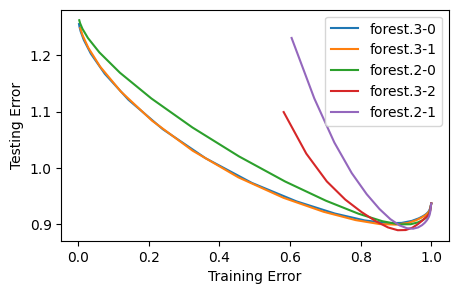

In [65]:
plt.figure(figsize=(5,3))

for ds_name, result in results.items():
    plt.plot(result['train_mses'], result['test_mses'], label = ds_name)
plt.legend()
plt.xlabel('Training Error')
plt.ylabel('Testing Error')
plt.savefig('forest_train_test.pdf')

/home/yutongw/miniconda3/envs/ml/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


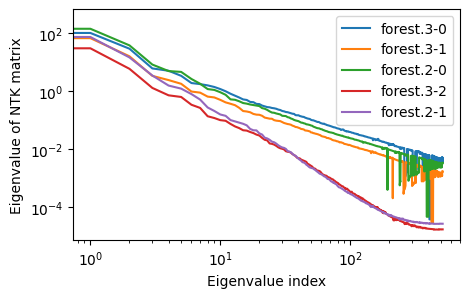

In [64]:
plt.figure(figsize=(5,3))

for ds_name, result in results.items():
    plt.loglog(result['eigenvalues'], label = ds_name)
plt.legend()
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue of NTK matrix')
plt.savefig('forest_eigenvalues.pdf')